In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics

In [2]:
PERP_df = pd.read_csv('C:/Users/spenc/Desktop/Prop trading firm/Neural networks/Crypto data/ETHPERP_1min.csv')
PERP_df.set_index('time', inplace=True)

Spot_df = pd.read_csv('C:/Users\spenc/Desktop/Prop trading firm/Neural networks/Crypto data/ETHUSD_1min.csv')
Spot_df.set_index('time', inplace=True)

In [3]:
main_df = pd.DataFrame()

main_df['PERP_open'] = PERP_df['open']
main_df['Spot_open'] = Spot_df['open']

main_df['PERP_close'] = PERP_df['close']
main_df['Spot_close'] = Spot_df['close']

Spot_open = main_df['Spot_open']
PERP_open = main_df['PERP_open']

main_df.dropna(inplace=True)
main_df

PERP_open  Spot_open  PERP_close  Spot_close
time                                                      
1.609452e+12     738.97     738.79      739.14      738.96
1.609452e+12     739.14     738.96      739.11      738.87
1.609452e+12     739.11     738.87      738.92      738.69
1.609452e+12     738.92     738.69      738.41      738.39
1.609452e+12     738.41     738.39      736.94      736.78
...                 ...        ...         ...         ...
1.653912e+12    1900.10    1899.70     1900.10     1899.90
1.653912e+12    1900.10    1899.90     1899.30     1898.90
1.653912e+12    1899.30    1898.90     1899.80     1899.30
1.653912e+12    1899.80    1899.30     1898.80     1898.40
1.653912e+12    1898.80    1898.40     1901.70     1901.40

[740883 rows x 4 columns]

In [4]:
main_df['spread'] = main_df['PERP_open'].sub(main_df['Spot_open'], axis=0)
main_df['close_spread'] = main_df['PERP_close'].sub(main_df['Spot_close'], axis=0)

spread = main_df['spread']
close_spread = main_df['close_spread']

main_df

PERP_open  Spot_open  PERP_close  Spot_close  spread  \
time                                                                 
1.609452e+12     738.97     738.79      739.14      738.96    0.18   
1.609452e+12     739.14     738.96      739.11      738.87    0.18   
1.609452e+12     739.11     738.87      738.92      738.69    0.24   
1.609452e+12     738.92     738.69      738.41      738.39    0.23   
1.609452e+12     738.41     738.39      736.94      736.78    0.02   
...                 ...        ...         ...         ...     ...   
1.653912e+12    1900.10    1899.70     1900.10     1899.90    0.40   
1.653912e+12    1900.10    1899.90     1899.30     1898.90    0.20   
1.653912e+12    1899.30    1898.90     1899.80     1899.30    0.40   
1.653912e+12    1899.80    1899.30     1898.80     1898.40    0.50   
1.653912e+12    1898.80    1898.40     1901.70     1901.40    0.40   

              close_spread  
time                        
1.609452e+12          0.18  
1.609452e+12          0.24  
1.609452e+12          0.23  
1.609452e+12          0.02  
1.609452e+12          0.16  
...                    ...  
1.653912e+12          0.20  
1.653912e+12          0.40  
1.653912e+12          0.50  
1.653912e+12          0.40  
1.653912e+12          0.30  

[740883 rows x 6 columns]

### Data exploration

Spreads are calculated as the difference between perpetual futures open prices and spot open prices.

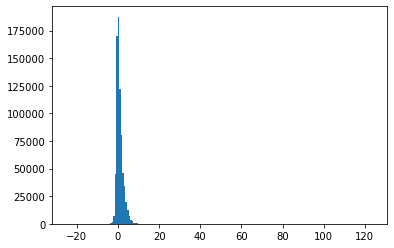

In [5]:
plt.hist(spread, bins=200)
plt.show()

Given the skewness of some of the spread distributions, the standard deviation may have little meaning. Instead the interquartile range may provide a better view of the measure of data distribution.

In [7]:
q3, q2, q1 = np.percentile(list(main_df['spread']), [75, 50 ,25])
iqr = q3 - q1

mean = statistics.mean(list(main_df['spread']))

std = statistics.stdev(list(main_df['spread']))

print(f'Q3 = {q3}, Median = {q2}, Q1 = {q1}, IQR = {iqr}')
print(f'Mean = {mean}')
print(f'Std = {std}')

Q3 = 1.599999999999909, Median = 0.5, Q1 = -0.1999999999998181, IQR = 1.7999999999997272
Mean = 0.8508270131721203
Std = 1.604662924635067


Potential strategy variations

1. Execute signal is given when (Total fees + Q3 + Mean spread) < spread. Trades are closed when the spread falls below the Q3 spread. Spreads are evaluated on the closing price.

### Strategy

In [8]:
# adding fees
main_df['total_fees'] = 0.0028*(main_df['Spot_open'] + main_df['PERP_open'])
main_df['Mean'] = mean
main_df['Q3'] = q3
main_df['Std'] = std
main_df['Median'] = q2

If BTCUSD > BTCPERP then long BTCPERP and short BTCUSD if possible (0) else if BTCUSD < BTCPERP then short BTCPERP (1) and long BTCUSD if possible.

0 = long BTCPERP, short BTCUSD

1 = short BTCPERP, long BTCUSD

In this case, we are only looking to short BTCPERP and long BTCUSD.

Execute encodes whether trades are executed. Instead of using absolute spreads, spreads are used to filter out unwanted trades. Execution is only possible where spreads > fees + threshold(based on some statistic).

In [9]:
execute = pd.DataFrame(np.where(main_df['spread'] > (main_df['total_fees'] + mean), 1, 0))
execute.index = main_df.index
execute.columns = ['Execute']

# creating new dataframe called comb_df
comb_df = pd.concat([main_df, execute], axis=1)
comb_df

PERP_open  Spot_open  PERP_close  Spot_close  spread  \
time                                                                 
1.609452e+12     738.97     738.79      739.14      738.96    0.18   
1.609452e+12     739.14     738.96      739.11      738.87    0.18   
1.609452e+12     739.11     738.87      738.92      738.69    0.24   
1.609452e+12     738.92     738.69      738.41      738.39    0.23   
1.609452e+12     738.41     738.39      736.94      736.78    0.02   
...                 ...        ...         ...         ...     ...   
1.653912e+12    1900.10    1899.70     1900.10     1899.90    0.40   
1.653912e+12    1900.10    1899.90     1899.30     1898.90    0.20   
1.653912e+12    1899.30    1898.90     1899.80     1899.30    0.40   
1.653912e+12    1899.80    1899.30     1898.80     1898.40    0.50   
1.653912e+12    1898.80    1898.40     1901.70     1901.40    0.40   

              close_spread  total_fees      Mean   Q3       Std  Median  \
time                                                                      
1.609452e+12          0.18    4.137728  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.24    4.138680  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.23    4.138344  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.02    4.137308  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.16    4.135040  0.850827  1.6  1.604663     0.5   
...                    ...         ...       ...  ...       ...     ...   
1.653912e+12          0.20   10.639440  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.40   10.640000  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.50   10.634960  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.40   10.637480  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.30   10.632160  0.850827  1.6  1.604663     0.5   

              Execute  
time                   
1.609452e+12        0  
1.609452e+12        0  
1.609452e+12        0  
1.609452e+12        0  
1.609452e+12        0  
...               ...  
1.653912e+12        0  
1.653912e+12        0  
1.653912e+12        0  
1.653912e+12        0  
1.653912e+12        0  

[740883 rows x 12 columns]

Exit encodes where the spread between the close prices is below the determined exit point.

In [10]:
exit = pd.DataFrame(np.where(comb_df['close_spread'] < mean, 1, 0))
exit.index = comb_df.index
exit.columns = ['Exit']
comb_df = pd.concat([comb_df, exit], axis=1)
comb_df

PERP_open  Spot_open  PERP_close  Spot_close  spread  \
time                                                                 
1.609452e+12     738.97     738.79      739.14      738.96    0.18   
1.609452e+12     739.14     738.96      739.11      738.87    0.18   
1.609452e+12     739.11     738.87      738.92      738.69    0.24   
1.609452e+12     738.92     738.69      738.41      738.39    0.23   
1.609452e+12     738.41     738.39      736.94      736.78    0.02   
...                 ...        ...         ...         ...     ...   
1.653912e+12    1900.10    1899.70     1900.10     1899.90    0.40   
1.653912e+12    1900.10    1899.90     1899.30     1898.90    0.20   
1.653912e+12    1899.30    1898.90     1899.80     1899.30    0.40   
1.653912e+12    1899.80    1899.30     1898.80     1898.40    0.50   
1.653912e+12    1898.80    1898.40     1901.70     1901.40    0.40   

              close_spread  total_fees      Mean   Q3       Std  Median  \
time                                                                      
1.609452e+12          0.18    4.137728  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.24    4.138680  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.23    4.138344  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.02    4.137308  0.850827  1.6  1.604663     0.5   
1.609452e+12          0.16    4.135040  0.850827  1.6  1.604663     0.5   
...                    ...         ...       ...  ...       ...     ...   
1.653912e+12          0.20   10.639440  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.40   10.640000  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.50   10.634960  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.40   10.637480  0.850827  1.6  1.604663     0.5   
1.653912e+12          0.30   10.632160  0.850827  1.6  1.604663     0.5   

              Execute  Exit  
time                         
1.609452e+12        0     1  
1.609452e+12        0     1  
1.609452e+12        0     1  
1.609452e+12        0     1  
1.609452e+12        0     1  
...               ...   ...  
1.653912e+12        0     1  
1.653912e+12        0     1  
1.653912e+12        0     1  
1.653912e+12        0     1  
1.653912e+12        0     1  

[740883 rows x 13 columns]

In [11]:
# counting the number of trade executes
np.unique(comb_df['Execute'], return_counts=True)

(array([0, 1]), array([740759,    124], dtype=int64))

In [12]:
# viewing the order executions
orders_fulfilled = comb_df.loc[comb_df['Execute']==1]
orders_fulfilled

PERP_open  Spot_open  PERP_close  Spot_close  spread  \
time                                                                 
1.609713e+12     993.70     986.70     1001.34      994.73    7.00   
1.609717e+12    1021.57    1013.40     1017.21     1013.42    8.17   
1.609745e+12    1083.92    1076.93     1062.89     1056.35    6.99   
1.609745e+12    1059.26    1050.77     1046.81     1035.36    8.49   
1.609745e+12    1046.69    1035.36     1056.56     1047.48   11.33   
...                 ...        ...         ...         ...     ...   
1.621680e+12    2480.00    2463.50     2462.20     2458.70   16.50   
1.630875e+12    3973.00    3933.90     3955.60     3949.80   39.10   
1.634576e+12    3723.50    3600.00     3725.70     3723.90  123.50   
1.637032e+12    4335.20    4308.20     4325.80     4325.90   27.00   
1.638595e+12    3920.30    3889.90     3938.20     3934.80   30.40   

              close_spread  total_fees      Mean   Q3       Std  Median  \
time                                                                      
1.609713e+12          6.61    5.545120  0.850827  1.6  1.604663     0.5   
1.609717e+12          3.79    5.697916  0.850827  1.6  1.604663     0.5   
1.609745e+12          6.54    6.050380  0.850827  1.6  1.604663     0.5   
1.609745e+12         11.45    5.908084  0.850827  1.6  1.604663     0.5   
1.609745e+12          9.08    5.829740  0.850827  1.6  1.604663     0.5   
...                    ...         ...       ...  ...       ...     ...   
1.621680e+12          3.50   13.841800  0.850827  1.6  1.604663     0.5   
1.630875e+12          5.80   22.139320  0.850827  1.6  1.604663     0.5   
1.634576e+12          1.80   20.505800  0.850827  1.6  1.604663     0.5   
1.637032e+12         -0.10   24.201520  0.850827  1.6  1.604663     0.5   
1.638595e+12          3.40   21.868560  0.850827  1.6  1.604663     0.5   

              Execute  Exit  
time                         
1.609713e+12        1     0  
1.609717e+12        1     0  
1.609745e+12        1     0  
1.609745e+12        1     0  
1.609745e+12        1     0  
...               ...   ...  
1.621680e+12        1     0  
1.630875e+12        1     0  
1.634576e+12        1     0  
1.637032e+12        1     1  
1.638595e+12        1     0  

[124 rows x 13 columns]

### Simulating the strategy

The strategy relies on being able to enter at or near the open price and exit at or near the close price of the security. Trades are therefore open at the beginning of candles and only closed at the end of candles when the exit criteria is met.

The tunable parameters within the strategy are the entry and exit rules relying on statistics. These can be tuned to provide the best trade-off between return and time in the market. We want to maximise return but minimize the length of time for which a trade is open. Owing to the low returns provided by arbitrage, large percentages of the account must be committed to trades. Whilst an arbitrage trade is open, we cannot take advantage of other potentially more lucrative arbitrage opportunities.

In simulating the strategy, we know that we are going to short perpetual futures and long spot.

In [13]:
Trade_counter = 0
Trade_open = 0

In [14]:
# lists of df cols
Spot_open = comb_df['Spot_open'].values
PERP_open = comb_df['PERP_open'].values
Spot_close = comb_df['Spot_close'].values
PERP_close = comb_df['PERP_close'].values
spread = comb_df['spread'].values
close_spread = comb_df['close_spread'].values
total_fees = comb_df['total_fees'].values
execute = comb_df['Execute'].values
exit = comb_df['Exit'].values
timestamps = comb_df.index.values

In [15]:
trades = ({
    'Spot_price_diff':[],
    'Perp_price_diff' :[],
    'Duration':[],
    'Total_fees':[],
    'Total_return': [],
    'Total_return_%': []
               })
trade_df = pd.DataFrame(trades)
trade_df

Empty DataFrame
Columns: [Spot_price_diff, Perp_price_diff, Duration, Total_fees, Total_return, Total_return_%]
Index: []

In [19]:
import warnings
warnings.filterwarnings('ignore')
for num in range(1, len(comb_df)):
    if execute[num] == 1 and Trade_open == 0:
        Spot_trade_open = Spot_open[num]
        Perp_trade_open = PERP_open[num]
        Trade_open_fees = 0.0007*Spot_open[num]+0.0007*PERP_open[num]
        Trade_open_time = timestamps[num]
        
        Trade_counter += 1
        Trade_open += 1
        
    if Trade_open == 1 and exit[num] == 1:
        Spot_trade_close = Spot_close[num]
        Perp_trade_close = PERP_close[num]
        Trade_close_fees = 0.0007*(Spot_close[num])+0.0007*(PERP_close[num])
        Trade_close_time = timestamps[num]
        
        Trade_open -= 1
        
        Spot_price_diff = Spot_trade_close - Spot_trade_open
        Perp_price_diff = Perp_trade_open - Perp_trade_close
        Duration = Trade_close_time - Trade_open_time
        Total_fees = Trade_open_fees + Trade_close_fees
        Total_return = (Spot_price_diff + Perp_price_diff)-Total_fees
        Total_return_percent = Total_return/(Spot_trade_open+Perp_trade_open)*100
        
        new_row = {'Spot_price_diff':Spot_price_diff, 'Perp_price_diff':Perp_price_diff, 
                   'Duration':Duration, 'Total_fees':Total_fees, 'Total_return':Total_return,
                   'Total_return_%':Total_return_percent}
        trade_df = trade_df.append(new_row, ignore_index=True)

In [17]:
trade_df

Spot_price_diff  Perp_price_diff    Duration  Total_fees  Total_return  \
0            -21.16            27.97  40740000.0    2.738169      4.071831   
1             -4.14            12.89  20040000.0    3.270407      5.479593   
2             73.69           -47.87   3000000.0    3.354568     22.465432   
3            -29.73            37.32   7800000.0    3.484943      4.105057   
4           -107.70           121.80  25860000.0    3.133690     10.966310   
5             40.40           -18.90   5100000.0    3.011750     18.488250   
6             65.70           -57.80   2400000.0    2.808610      5.091390   
7              2.90             4.80    420000.0    2.670850      5.029150   
8             95.00           -86.60  55800000.0    3.827600      4.572400   
9             11.20            23.00         0.0    3.891160     30.308840   
10            28.70           -19.30   2520000.0    3.850000      5.550000   
11           140.10          -131.60  76500000.0    4.120690      4.379310   
12             8.40             4.70  79020000.0    4.836510      8.263490   
13            42.70           -22.90    660000.0    4.847920     14.952080   
14           126.00           -54.50  88500000.0    5.406870     66.093130   
15            67.80           -50.90    180000.0    4.473770     12.426230   
16            -0.90            16.90         0.0    4.662000     11.338000   
17           -63.00            77.10  41520000.0    6.618710      7.481290   
18           113.60           -99.70  25080000.0    6.736730      7.163270   
19            33.50           -13.40         0.0    5.838490     14.261510   
20             4.30            12.10         0.0    6.540940      9.859060   
21             4.50            10.60    420000.0    6.542410      8.557590   
22           151.80          -108.40   2340000.0   10.648680     32.751320   
23           139.20           -72.00    120000.0    7.248220     59.951780   
24           205.70          -132.90    480000.0    5.959940     66.840060   
25          -111.00           143.40    240000.0    5.971420     26.428580   
26           221.60          -193.40    240000.0    5.561780     22.638220   
27           117.10           -78.80     60000.0    6.837110     31.462890   
28           257.00          -217.10   1440000.0    7.290850     32.609150   
29           -60.90            76.60   2820000.0    6.824650      8.875350   
30           -22.70            61.00  24360000.0   11.011070     27.288930   
31           128.40            -5.60    360000.0   10.346700    112.453300   
32            17.70             9.40         0.0   12.106570     14.993430   
33            63.20           -32.10     60000.0   11.000990     20.099010   

    Total_return_%  
0         0.205606  
1         0.233719  
2         0.961977  
3         0.162720  
4         0.466037  
5         0.871430  
6         0.261849  
7         0.263486  
8         0.172987  
9         1.088171  
10        0.203595  
11        0.155986  
12        0.239327  
13        0.435921  
14        1.752297  
15        0.396219  
16        0.339573  
17        0.155935  
18        0.152238  
19        0.343908  
20        0.210844  
21        0.183003  
22        0.438080  
23        1.182085  
24        1.635111  
25        0.601675  
26        0.601249  
27        0.657435  
28        0.656027  
29        0.179536  
30        0.345128  
31        1.535513  
32        0.173467  
33        0.257343

In [18]:
total_return = trade_df['Total_return_%'].sum()
average_duration = (trade_df['Duration'].mean())/(1000*60)

print(f'Total percentage return: {total_return} \n Average duration: {average_duration} minutes')

Total percentage return: 17.519477522569858 
 Average duration: 249.05882352941177 minutes
